# Make some of the KNMI23 figures

In [1]:
root = '/Users/dewilebars/Projects/'
budget_dir = f'{root}/SLBudget/'
slproj_dir = f'{root}/Project_ProbSLR/SLProj/'

import sys
sys.path.append(f'{budget_dir}code')
sys.path.append(f'{slproj_dir}code')
import importlib

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import statsmodels.api as sm
import xarray as xr
import numpy as np
from scipy.stats import linregress
from scipy.interpolate import interp1d
from numpy.polynomial import Polynomial

import SeaLevelContrib as slc
import func_misc as misc
import knmi23_module as knmi23

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

In [2]:
importlib.reload(slc)
importlib.reload(knmi23)

<module 'knmi23_module' from '/Users/dewilebars/Projects/KNMIClimateScenarios2021-2023/2023_KNMI2023/KNMI23_SeaLevelScenarios/knmi23_module.py'>

In [3]:
Projects_dir = '/Users/dewilebars/Projects/'
ProbSLR_dir = f'{Projects_dir}Project_ProbSLR/SLProj/'

fig_dir = './figures'

In [52]:
# Specify colors
rgb_red = '#d52b1e'
rgb_orange = '#f68e64'
rgb_yellow = '#fec35e'

## Sea level observations time series

### Read budget data

In [4]:
path_slb = f'{Projects_dir}SLBudget/outputs/'

budget_tg_df = pd.read_csv(path_slb+
                        'slbudget_2022_11_23_ZSM_tide_gauge_1950_2021_ERA5_StericEN4_22_[500, 4000]m.csv')

budget_alti_df = pd.read_csv(path_slb+
                        'slbudget_2022_12_01_NL_region_altimetry_1993_2021_ERA5_StericEN4_22_[500, 4000]m.csv')

budget_tg_df.set_index('time', inplace=True)
budget_alti_df.set_index('time', inplace=True)

# Center the index to the middle to the years
budget_tg_df.index = budget_tg_df.index+0.5

budget_tg_df

,Total,LocSteric,GloSteric,GIA,Glaciers,Antarctica,Greenland,TWS,Nodal,Wind,Pressure,Obs
time,,,,,,,,,,,,
1950.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.580712
1951.5,-5.780009,-3.665236,0.097124,0.036833,0.054167,0.004167,0.006667,0.360000,0.007106,-3.187448,0.506611,1.047379
1952.5,-2.983398,-2.856293,0.176444,0.073667,0.115833,0.010000,0.011667,0.333333,-0.046784,-0.669538,-0.131727,3.480712
1953.5,-3.471756,-0.499573,0.177486,0.110500,0.186667,0.014167,0.017500,0.296667,-0.155587,-1.477534,-2.142049,-0.419288
1954.5,3.989206,-0.021989,0.193522,0.147333,0.242500,0.019167,0.020000,0.148333,-0.307016,3.340130,0.207225,2.347379
...,...,...,...,...,...,...,...,...,...,...,...,...
2017.5,12.027647,1.650100,4.838131,2.467833,2.657500,0.850833,0.269167,-0.684167,-1.030123,1.930466,-0.922094,18.114046
2018.5,6.309250,1.168228,4.889651,2.504667,2.677500,0.959167,0.276667,-0.811667,-0.928142,-3.614668,-0.812152,10.830712
2019.5,11.140404,2.074197,5.082026,2.541500,2.725333,0.990444,0.286778,-0.516500,-0.781557,-1.051020,-0.210798,17.814046


In [5]:
# Adjust to AR6 reference period
tg_obs = budget_tg_df['Obs'] - budget_tg_df.loc[1995.5:2014.5, 'Obs'].mean()

tg_19ra = tg_obs.rolling(19, center=True).mean()
tg_19ra = tg_19ra.dropna()

## Figure projections

In [6]:
proj_data_dir = f'{ProbSLR_dir}/outputs/KNMI23/'

KNMI23_ssp126 = xr.open_dataset(f'{proj_data_dir}SeaLevelPerc_KNMI23_ssp126_v19.nc')
KNMI23_ssp245 = xr.open_dataset(f'{proj_data_dir}SeaLevelPerc_KNMI23_ssp245_v19.nc')
KNMI23_ssp585 = xr.open_dataset(f'{proj_data_dir}SeaLevelPerc_KNMI23_ssp585_v19.nc')

KNMI23_ssp126 = knmi23.new_ref_period(KNMI23_ssp126.perc_ts)
KNMI23_ssp245 = knmi23.new_ref_period(KNMI23_ssp245.perc_ts)
KNMI23_ssp585 = knmi23.new_ref_period(KNMI23_ssp585.perc_ts)


In [70]:
def make_proj_figure(proj_26, proj_45, proj_85):
    
    fig, ax = plt.subplots(figsize=(4,4))
    alpha_val = 0.4
    
    center = '50'
    p_low = '5'
    p_high = '95'
    
    ax.fill_between(proj_26.time[:-6], 
                    proj_26.sel(proc='Total', percentiles=p_low)[:-6], 
                    proj_26.sel(proc='Total', percentiles=p_high)[:-6], 
                    color=rgb_yellow,
                    alpha=alpha_val,
                   label='ssp126')
    ax.fill_between(proj_45.time[:-3], 
                    proj_45.sel(proc='Total', percentiles=p_low)[:-3], 
                    proj_45.sel(proc='Total', percentiles=p_high)[:-3], 
                    color=rgb_orange,
                    alpha=alpha_val,
                   label='ssp245')
    ax.fill_between(proj_85.time, 
                    proj_85.sel(proc='Total', percentiles=p_low), 
                    proj_85.sel(proc='Total', percentiles=p_high), 
                    color=rgb_red,
                    alpha=alpha_val,
                   label='ssp585')

    proj_26.sel(proc='Total', percentiles=center)[:-6].plot(color=rgb_yellow)
    proj_45.sel(proc='Total', percentiles=center)[:-3].plot(color=rgb_orange)
    proj_85.sel(proc='Total', percentiles=center).plot(color=rgb_red)

    tg_19ra.plot(color='tab:blue',label='Tide gauge observations')

    plt.grid()
    plt.legend(loc='upper left')
    plt.xlabel('Time [years]')
    plt.ylabel('Sea level [cm]')
    
    return ax

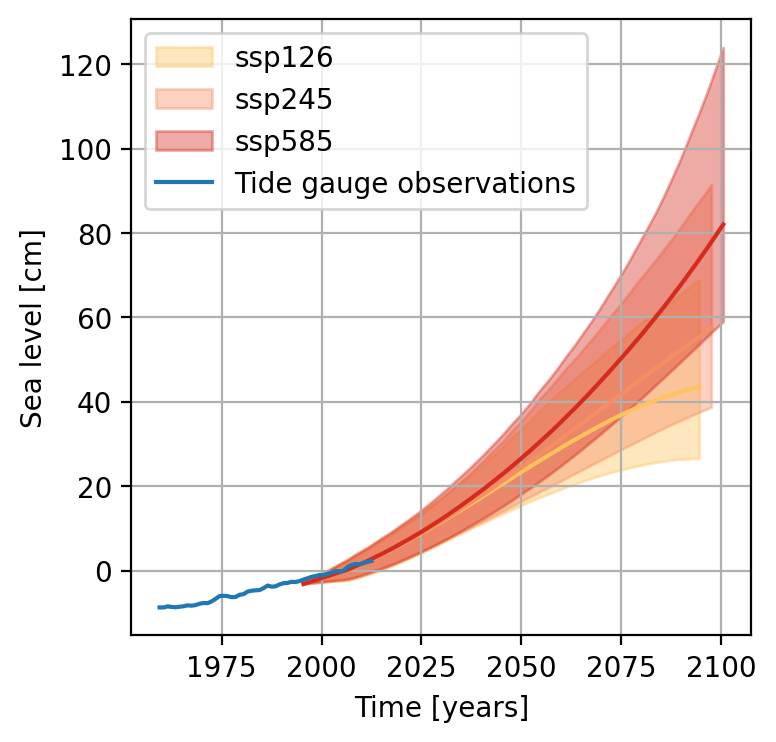

In [71]:
ax = make_proj_figure(KNMI23_ssp126, KNMI23_ssp245, KNMI23_ssp585)


plt.title('');
#plt.savefig(f'{fig_dir}/Projection_NoBiasCorrection.pdf' ,dpi=150)

### Export data as csv files

In [9]:
def make_df(ds, sce_name):
    df = pd.DataFrame({'time' : ds.time,
                       f'{sce_name}_5pc' : ds.sel(proc='Total', percentiles='5'),
                       f'{sce_name}_17pc' : ds.sel(proc='Total', percentiles='17'),
                       f'{sce_name}_50pc' : ds.sel(proc='Total', percentiles='50'),
                       f'{sce_name}_83pc' : ds.sel(proc='Total', percentiles='83'),
                       f'{sce_name}_95pc' : ds.sel(proc='Total', percentiles='95')})
    df = df.set_index('time')

    return df

In [10]:
proj_scen = ['ssp126', 'ssp245', 'ssp585']
list_ds = [KNMI23_ssp126, KNMI23_ssp245, KNMI23_ssp585]

list_proj = []
list_proj.append(tg_19ra)

for i in range(3):
    df = make_df(list_ds[i], proj_scen[i])
    list_proj.append(df)

all_df = pd.concat(list_proj, axis=1)
all_df

,Obs,ssp126_5pc,ssp126_17pc,ssp126_50pc,ssp126_83pc,ssp126_95pc,ssp245_5pc,ssp245_17pc,ssp245_50pc,ssp245_83pc,ssp245_95pc,ssp585_5pc,ssp585_17pc,ssp585_50pc,ssp585_83pc,ssp585_95pc
time,,,,,,,,,,,,,,,,
1959.5,-8.677763,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960.5,-8.676886,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1961.5,-8.420746,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962.5,-8.557588,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963.5,-8.637412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2096.5,NaN,26.623250,33.504823,43.928723,57.373459,70.107472,38.342394,45.563733,56.791199,72.837651,90.054940,55.476511,63.638714,76.437322,95.010774,113.434801
2097.5,NaN,26.604376,33.572171,44.130218,57.822969,70.796290,38.732878,46.065270,57.480857,73.897267,91.459105,56.405339,64.742130,77.838007,96.966580,116.090681
2098.5,NaN,26.510713,33.559050,44.258245,58.234574,71.458495,39.040768,46.497714,58.115506,74.904247,92.785510,57.275086,65.800131,79.209895,98.912729,118.703476


In [11]:
file_path = f'./outputs/DataKNMI23_SeaLevel_2100_ref_period_1995_2014.csv'

all_df.to_csv(file_path)

### Print the numbers

In [12]:
def print_numbers(proj_26, proj_45, proj_85, years):
    
    proj = [proj_26, proj_45, proj_85]
    proj_scen = ['ssp126', 'ssp245', 'ssp585']
    
    for idx, p in enumerate(proj):
        print('')
        print(f'Scenario: {proj_scen[idx]}')
        
        for year in years:
            print(year)
            print('Level in cm')
            print('Median, 5pc, 95pc')
            ps = p.sel(proc='Total', time=year)
            med = int(round(ps.sel(percentiles='50').values.item()))
            fpc = int(round(ps.sel(percentiles='5').values.item()))
            npc = int(round(ps.sel(percentiles='95').values.item()))
            print(f'{med}, {fpc}, {npc}')
            
            print('Speed in mm/y')
            ps = p.sel(proc='Total', time=slice(year-5,year+5))
            med = round(linregress(ps.time, ps.sel(percentiles='50'))[0]*10,1)
            fpc = round(linregress(ps.time, ps.sel(percentiles='5'))[0]*10,1)
            npc = round(linregress(ps.time, ps.sel(percentiles='95'))[0]*10,1)
            print(f'{med}, {fpc}, {npc}')
            

In [13]:
years = [2050.5, 2100.5]
print_numbers(KNMI23_ssp126, KNMI23_ssp245, KNMI23_ssp585, years)


Scenario: ssp126
2050.5
Level in cm
Median, 5pc, 95pc
24, 16, 34
Speed in mm/y
5.9, 4.2, 9.2
2100.5
Level in cm
Median, 5pc, 95pc
44, 26, 73
Speed in mm/y
1.5, -0.6, 6.4

Scenario: ssp245
2050.5
Level in cm
Median, 5pc, 95pc
25, 17, 36
Speed in mm/y
6.8, 5.0, 10.8
2100.5
Level in cm
Median, 5pc, 95pc
59, 40, 95
Speed in mm/y
6.6, 3.4, 13.2

Scenario: ssp585
2050.5
Level in cm
Median, 5pc, 95pc
27, 19, 38
Speed in mm/y
8.2, 6.4, 11.3
2100.5
Level in cm
Median, 5pc, 95pc
82, 59, 124
Speed in mm/y
13.9, 8.9, 26.1


Build a dataframe that can easily be converted into a Latex table for the report

In [14]:
def make_numbers_df(ssp126_ds, ssp245_ds, ssp585_ds, y):
    
    index = ['Global steric', 'Ocean Dynamic Sea Level', 
             'Glaciers', 'Landwater', 'Greenland', 'Antarctica', 'GIA', 'Total']

    scen = ['SSP1-2.6', 'SSP2-4.5', 'SSP5-8.5']
    
    df = pd.DataFrame(index=index, columns = scen)
    
    for proc in index:
        nlist = []
        
        for ds in [ssp126_ds, ssp245_ds, ssp585_ds]:
            sel_ds = ds.sel(proc=proc, time=y)
            np50 = round(sel_ds.sel(percentiles='50').data.item())
            np5 = round(sel_ds.sel(percentiles='5').data.item())
            np95 = round(sel_ds.sel(percentiles='95').data.item())
            nlist.append(f'{np50} ({np5} to {np95}) cm')
        
        df.loc[proc,:] = nlist

    # Also add the rate [mm/yr]
    nlist = []

    for ds in [ssp126_ds, ssp245_ds, ssp585_ds]:
        sel_ds = ds.sel(proc='Total', time=slice(y-5,y+5))
        np50 = round(linregress(sel_ds.time, sel_ds.sel(percentiles='50'))[0]*10,1)
        np5 = round(linregress(sel_ds.time, sel_ds.sel(percentiles='5'))[0]*10,1)
        np95 = round(linregress(sel_ds.time, sel_ds.sel(percentiles='95'))[0]*10,1)
        nlist.append(f'{np50} ({np5} to {np95}) mm/yr')
    
    df.loc['Rate total',:] = nlist
    
    return df

In [15]:
df_2050 = make_numbers_df(KNMI23_ssp126, KNMI23_ssp245, KNMI23_ssp585, 2050.5)

df_2050

,SSP1-2.6,SSP2-4.5,SSP5-8.5
Global steric,8 (5 to 10) cm,8 (6 to 11) cm,9 (6 to 12) cm
Ocean Dynamic Sea Level,7 (2 to 11) cm,7 (2 to 11) cm,8 (3 to 12) cm
Glaciers,3 (2 to 4) cm,3 (2 to 4) cm,3 (2 to 5) cm
Landwater,1 (1 to 1) cm,1 (1 to 1) cm,1 (1 to 1) cm
Greenland,1 (0 to 1) cm,1 (0 to 1) cm,1 (0 to 1) cm
Antarctica,3 (0 to 13) cm,3 (-1 to 14) cm,3 (-1 to 13) cm
GIA,2 (2 to 2) cm,2 (2 to 2) cm,2 (2 to 2) cm
Total,24 (16 to 34) cm,25 (17 to 36) cm,27 (19 to 38) cm
Rate total,5.9 (4.2 to 9.2) mm/yr,6.8 (5.0 to 10.8) mm/yr,8.2 (6.4 to 11.3) mm/yr


In [16]:
df_2100 = make_numbers_df(KNMI23_ssp126, KNMI23_ssp245, KNMI23_ssp585, 2100.5)

df_2100

,SSP1-2.6,SSP2-4.5,SSP5-8.5
Global steric,15 (10 to 20) cm,21 (14 to 27) cm,32 (22 to 42) cm
Ocean Dynamic Sea Level,7 (-2 to 16) cm,13 (5 to 21) cm,20 (9 to 30) cm
Glaciers,6 (3 to 8) cm,7 (4 to 11) cm,10 (6 to 15) cm
Landwater,2 (1 to 3) cm,2 (1 to 3) cm,2 (1 to 3) cm
Greenland,1 (1 to 2) cm,2 (1 to 3) cm,3 (2 to 5) cm
Antarctica,10 (-1 to 35) cm,10 (-1 to 44) cm,12 (-3 to 52) cm
GIA,4 (4 to 4) cm,4 (4 to 4) cm,4 (4 to 4) cm
Total,44 (26 to 73) cm,59 (40 to 95) cm,82 (59 to 124) cm
Rate total,1.5 (-0.6 to 6.4) mm/yr,6.6 (3.4 to 13.2) mm/yr,13.9 (8.9 to 26.1) mm/yr


In [17]:
print(df_2050.to_latex(escape = False))

\begin{tabular}{llll}
\toprule
{} &                SSP1-2.6 &                 SSP2-4.5 &                 SSP5-8.5 \\
\midrule
Global steric           &          8 (5 to 10) cm &           8 (6 to 11) cm &           9 (6 to 12) cm \\
Ocean Dynamic Sea Level &          7 (2 to 11) cm &           7 (2 to 11) cm &           8 (3 to 12) cm \\
Glaciers                &           3 (2 to 4) cm &            3 (2 to 4) cm &            3 (2 to 5) cm \\
Landwater               &           1 (1 to 1) cm &            1 (1 to 1) cm &            1 (1 to 1) cm \\
Greenland               &           1 (0 to 1) cm &            1 (0 to 1) cm &            1 (0 to 1) cm \\
Antarctica              &          3 (0 to 13) cm &          3 (-1 to 14) cm &          3 (-1 to 13) cm \\
GIA                     &           2 (2 to 2) cm &            2 (2 to 2) cm &            2 (2 to 2) cm \\
Total                   &        24 (16 to 34) cm &         25 (17 to 36) cm &         27 (19 to 38) cm \\
Rate total        

/var/folders/4x/jddrv9056c3bmvydrhcmv4gw0000gn/T/ipykernel_10866/74510257.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_2050.to_latex(escape = False))


In [18]:
print(df_2100.to_latex(escape = False))

\begin{tabular}{llll}
\toprule
{} &                 SSP1-2.6 &                 SSP2-4.5 &                  SSP5-8.5 \\
\midrule
Global steric           &         15 (10 to 20) cm &         21 (14 to 27) cm &          32 (22 to 42) cm \\
Ocean Dynamic Sea Level &          7 (-2 to 16) cm &          13 (5 to 21) cm &           20 (9 to 30) cm \\
Glaciers                &            6 (3 to 8) cm &           7 (4 to 11) cm &           10 (6 to 15) cm \\
Landwater               &            2 (1 to 3) cm &            2 (1 to 3) cm &             2 (1 to 3) cm \\
Greenland               &            1 (1 to 2) cm &            2 (1 to 3) cm &             3 (2 to 5) cm \\
Antarctica              &         10 (-1 to 35) cm &         10 (-1 to 44) cm &          12 (-3 to 52) cm \\
GIA                     &            4 (4 to 4) cm &            4 (4 to 4) cm &             4 (4 to 4) cm \\
Total                   &         44 (26 to 73) cm &         59 (40 to 95) cm &         82 (59 to 124) cm \\


/var/folders/4x/jddrv9056c3bmvydrhcmv4gw0000gn/T/ipykernel_10866/186454168.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_2100.to_latex(escape = False))


## Long term projections

### Read fingerprints from AR5 (Aimée Slangen)

In [19]:
# Use latitude 53ºN and longitude 5ºE
fingerprints = knmi23.read_constant_fp('AR5', 53, 5)

fingerprints

{'GIC': 0.7480514526367188,
 'GSMB': 0.20718278884887695,
 'ASMB': 1.0741610717773438,
 'GDYN': 0.2208646011352539,
 'ADYN': 1.1093885803222656,
 'GW': 0.7055201721191406}

Read the output csv file from the notebook "LongTermProj.ipynb"

In [20]:
long_df = pd.read_csv('./outputs/knmi23_long_term_projections.csv')
long_df.set_index('time', inplace=True)

In [21]:
long_df

,ssp126_17,ssp126_50,ssp126_83,ssp585_17,ssp585_50,ssp585_83
time,,,,,,
2006.5,-0.012542,0.001779,0.016415,-0.010719,0.002545,0.016137
2050.5,0.190123,0.236897,0.290540,0.220427,0.270789,0.327098
2100.5,0.335451,0.444990,0.589802,0.679603,0.820262,1.028879
2150.5,0.433882,0.678121,1.031564,1.087139,1.412424,1.998047
2300.5,0.559299,NaN,1.606270,2.102624,NaN,5.986942


In [86]:
def make_long_proj_figure(df, proj_scen): 
    fig, ax = plt.subplots(figsize=(5,5))
    alpha_val = 0.4
    color_v = [rgb_yellow, rgb_red]
    
    for scen_name, color in zip(proj_scen[0:2], color_v):
        ax.fill_between(df.index, 
                        df[f'{scen_name}_17'],  
                        df[f'{scen_name}_83'],
                        color=color,
                        alpha=alpha_val,
                        label=scen_name)
        df[f'{scen_name}_50'].plot(color=color, label='')
    
    plt.grid()
    plt.legend(loc='upper left')
    plt.ylabel('Sea level (m)')
    plt.xlabel('time (years)')
    
    return ax

Text(0.5, 0, 'Time [years]')

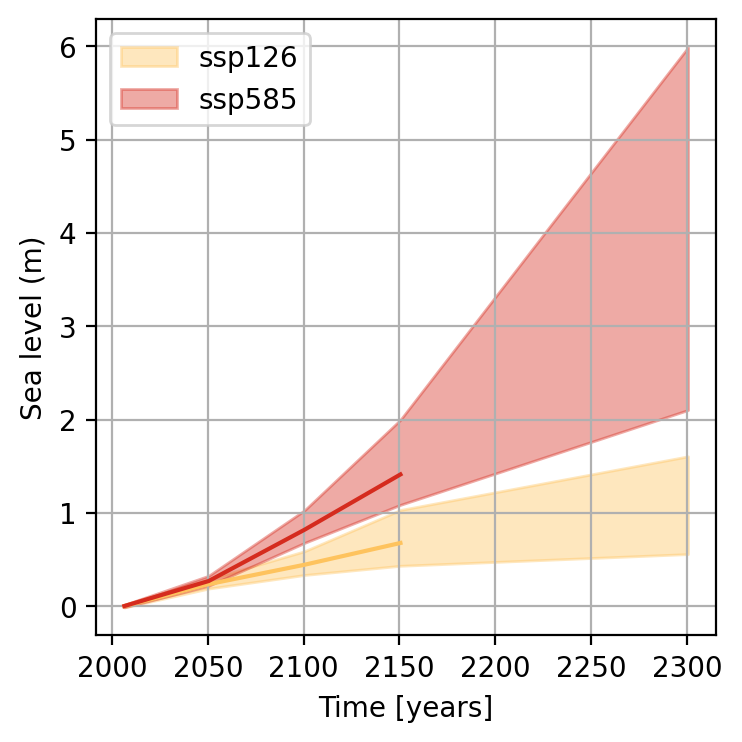

In [73]:
proj_scen = ['ssp126', 'ssp585']
ax = make_long_proj_figure(long_df, proj_scen)

ax.set_xlabel('Time [years]')

#plt.savefig(f'{fig_dir}/Projection_BiasCorrectionNoWind_longterm.pdf' ,dpi=150)

### Probability to reach a given level

## Low probability high impact (LPHI) scenarios

Read the outputs from the notebook "LPHI.ipynb"

In [60]:
lphi_ts_df = pd.read_csv('./outputs/knmi23_lphi_NL.csv')
lphi_ts_df.set_index('time', inplace=True)

lphi_ts_df.rename(columns={'vdw_high':'Physical evidence discussion', 
                           'mici_high':'Marine Ice Cliff Instability model', 
                           'sej_high': 'Structured Expert Judgement' }, 
                  inplace=True)

## Plot the projections adding the LPHI scenarios

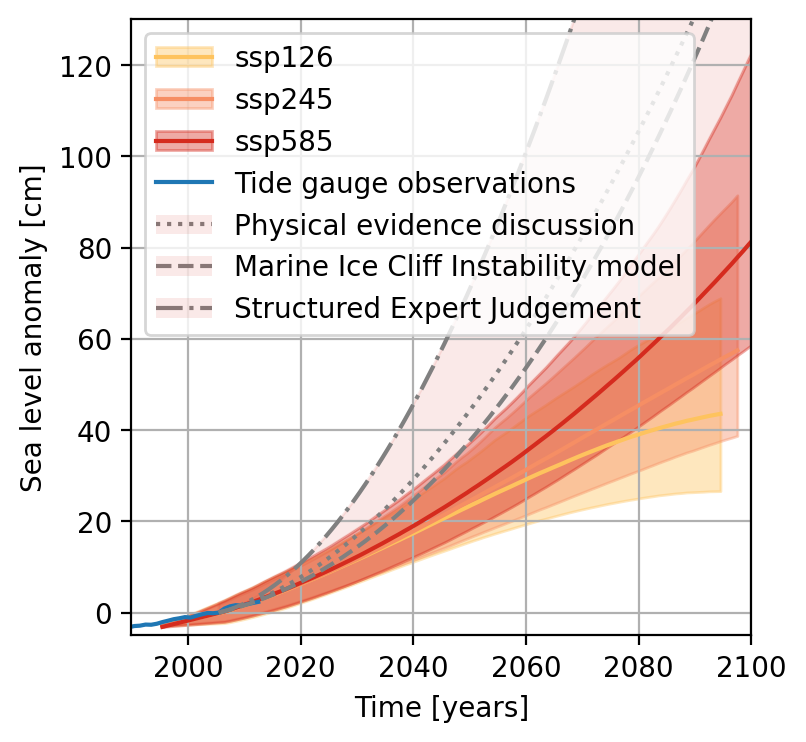

In [74]:
ax = make_proj_figure(KNMI23_ssp126, KNMI23_ssp245, KNMI23_ssp585)

(lphi_ts_df*100).plot(ax=ax, color='grey', style=[':', '--', '-.'])

ax.fill_between(lphi_ts_df.loc[2005:2101].index, 
                KNMI23_ssp585.sel(proc='Total', 
                                  percentiles='95', 
                                  time=slice(2005,2101)).data, 
                lphi_ts_df.loc[2005:2101].max(axis=1)*100, 
                color=rgb_red,
                alpha=0.1,
                label='')

# Adjust the legend
handles, labels = ax.get_legend_handles_labels()
handles[0] = (Line2D([], [], color=rgb_yellow), handles[0])
handles[1] = (Line2D([], [], color=rgb_orange), handles[1])
handles[2] = (Line2D([], [], color=rgb_red), handles[2])

for i in [4, 5, 6]:
    handles[i] = (handles[i], Patch(facecolor=rgb_red, alpha=0.1))
    
ax.legend(handles, labels)

ax.set_xlim([1990, 2100])
ax.set_ylim([-5, 130])
ax.set_ylabel('Sea level anomaly [cm]')
ax.set_xlabel('Time [years]')

plt.title('')
plt.grid()
plt.savefig(f'{fig_dir}/Scenario_KNMI23_2100.pdf' ,dpi=150)

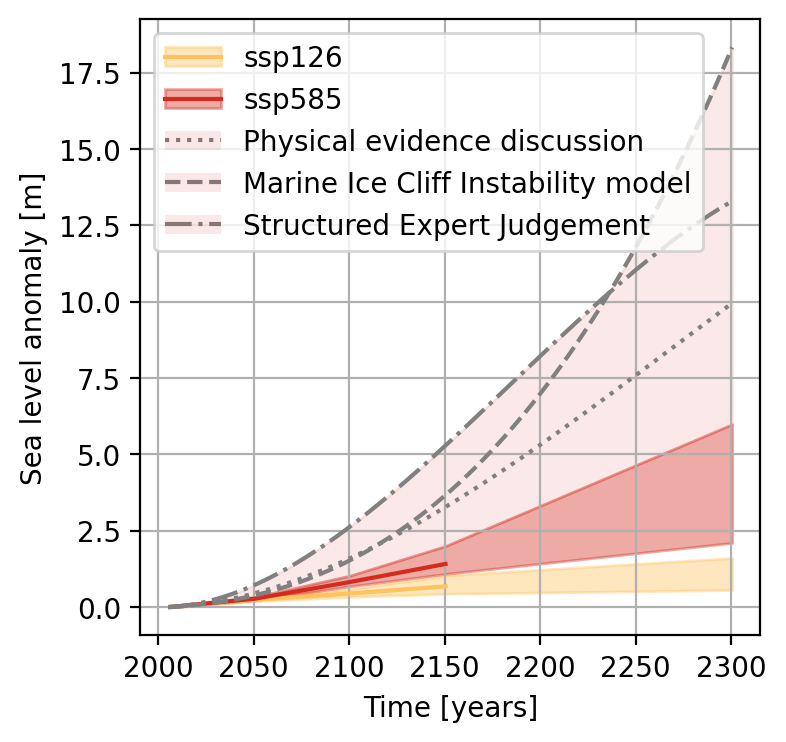

In [76]:
ax = make_long_proj_figure(long_df, proj_scen)

lphi_ts_df.plot(ax=ax, color='grey', style=[':', '--', '-.'])

ax.fill_between(lphi_ts_df.index, 
                long_df['ssp585_83'].reindex(lphi_ts_df.index).interpolate(), 
                lphi_ts_df.max(axis=1), 
                color=rgb_red,
                alpha=0.1,
                label='')

# Adjust the legend
handles, labels = ax.get_legend_handles_labels()
handles[0] = (Line2D([], [], color=rgb_yellow), handles[0])
handles[1] = (Line2D([], [], color=rgb_red), handles[1])

for i in [2, 3, 4]:
    handles[i] = (handles[i], Patch(facecolor='tab:red', alpha=0.1))
    
ax.legend(handles, labels)

ax.set_xlabel('Time [years]')
ax.set_ylabel('Sea level anomaly [m]')

plt.grid()
plt.savefig(f'{fig_dir}/Scenario_KNMI23_2300.pdf' ,dpi=150)

In [27]:
lphi_ts_df

,Physical evidence discussion,Marine Ice Cliff Instability model,Structured Expert Judgement
time,,,
2005.5,0.000000,0.000000,0.000000
2006.5,0.003165,0.003109,0.003316
2007.5,0.006659,0.006437,0.007261
2008.5,0.010481,0.009986,0.011833
2009.5,0.014630,0.013758,0.017026
...,...,...,...
2296.5,9.766885,17.741669,13.146928
2297.5,9.813482,17.887347,13.184159
2298.5,9.860048,18.033787,13.220990


## Compare the sea level rates of different projections (not finished)

In [43]:
def compute_rates(sl_proj, years, perc):

    rate_df = pd.DataFrame(index=years, columns=sl_proj.proc)
    
    for process in sl_proj.proc:
    
        for year in years:

            ps = sl_proj.sel(proc=process, time=slice(year-5,year+5))
            rate_df[process.values].loc[year] = round(linregress(ps.time, ps.sel(percentiles=perc))[0]*10,2)
            
            
    return rate_df


In [68]:
years2 = np.arange(2010,2101,5)

rate_26_50p = compute_rates(KNMIsigBNW_sub_26, years2, 50)
rate_45_50p = compute_rates(KNMIsigBNW_sub_45, years2, 50)


NameError: name 'KNMIsigBNW_sub_26' is not defined

In [38]:
def plot_rates(rate_df, title):

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

    rate_df['Total_with_sub'].plot(ax=axes[0])
    axes[0].set_ylabel('Sea level rate [mm/yr]')

    rate_df[['Global steric', 'Local ocean', 'Glaciers', 'Greenland SMB', 
             'Landwater', 'Greenland dynamics', 'sum anta.']].plot(ax=axes[1])
    axes[1].set_ylabel('Sea level rate [mm/yr]')
    
    plt.suptitle(title)

In [39]:
plot_rates(rate_26_50p, 'SSP-1.26')

#plt.savefig(f'{fig_dir}/Rate_processes_ssp126.pdf' ,dpi=150)

NameError: name 'rate_26_50p' is not defined

In [40]:
plot_rates(rate_45_50p, 'SSP-2.45')

#plt.savefig(f'{fig_dir}/Rate_processes_ssp245.pdf' ,dpi=150)

NameError: name 'rate_45_50p' is not defined

## Prepare specific figures for the KNMI'23 brochure

### Ice sheet mass loss

In [28]:
# Import data
data_imbie_dir = '/Users/dewilebars/Data/IMBIE_AR6/'

In [29]:
imbie_df = pd.read_excel(f'{data_imbie_dir}/IMBIE_AR6.xlsx', skiprows=1)

imbie_df.set_index('Year', inplace=True)

imbie_df  = imbie_df.iloc[:,5:9]
imbie_df.columns = ['GRIS', 'GRIS uncertainty', 'AIS', 'AIS uncertainty']

imbie_df['GRIS_lb'] = imbie_df['GRIS']-imbie_df['GRIS uncertainty']
imbie_df['GRIS_ub'] = imbie_df['GRIS']+imbie_df['GRIS uncertainty']

imbie_df['AIS_lb'] = imbie_df['AIS']-imbie_df['AIS uncertainty']
imbie_df['AIS_ub'] = imbie_df['AIS']+imbie_df['AIS uncertainty']

imbie_df

,GRIS,GRIS uncertainty,AIS,AIS uncertainty,GRIS_lb,GRIS_ub,AIS_lb,AIS_ub
Year,,,,,,,,
1992.0000,-0.6472,16.2813,2.5250,33.0081,-16.9285,15.6341,-30.4831,35.5331
1992.0833,-1.2944,23.0252,5.0500,46.6805,-24.3196,21.7308,-41.6305,51.7305
1992.1667,-1.9417,28.2000,7.5750,57.1717,-30.1417,26.2583,-49.5967,64.7467
1992.2500,-2.5889,32.5626,-3.3129,64.5389,-35.1515,29.9737,-67.8518,61.2260
1992.3333,-3.2361,36.4060,-14.2009,71.1473,-39.6421,33.1699,-85.3482,56.9464
...,...,...,...,...,...,...,...,...
2020.5833,-4761.4156,451.0452,-2641.6442,521.8805,-5212.4608,-4310.3704,-3163.5247,-2119.7637
2020.6667,-4794.1595,452.4609,-2648.8663,523.8783,-5246.6204,-4341.6986,-3172.7446,-2124.9880
2020.7500,-4826.9033,453.8721,-2656.0883,525.8685,-5280.7754,-4373.0312,-3181.9568,-2130.2198


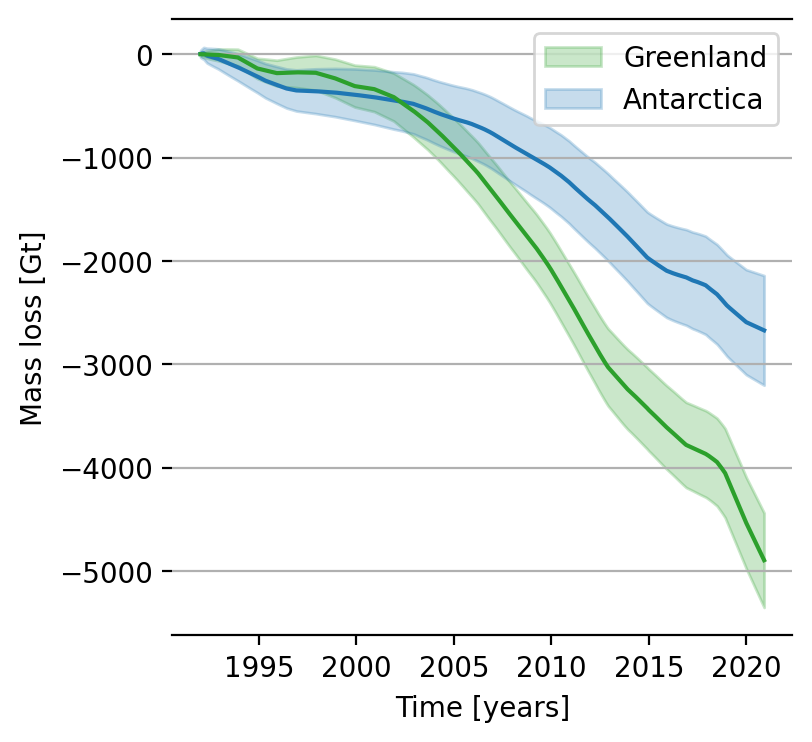

In [93]:
fig, ax = plt.subplots(figsize=(4,4))
alpha_val = 0.25

ax.fill_between(imbie_df.index, 
                imbie_df['GRIS_lb'], 
                imbie_df['GRIS_ub'], 
                color='tab:green',
                alpha=alpha_val,
               label='Greenland')
ax.fill_between(imbie_df.index, 
                imbie_df['AIS_lb'], 
                imbie_df['AIS_ub'], 
                color='tab:blue',
                alpha=alpha_val,
               label='Antarctica')

imbie_df['AIS'].plot(ax=ax, color='tab:blue', label='')
imbie_df['GRIS'].plot(ax=ax, color='tab:green', label='')

# Hide the left and right spines
ax.spines[['left', 'right']].set_visible(False)
ax.grid(axis='y')

plt.legend()
plt.xlabel('Time [years]')
plt.ylabel('Mass loss [Gt]')

plt.savefig(f'{fig_dir}/Figure_brochure_sealevel_icesheets.pdf', 
            bbox_inches="tight",
            dpi=150)

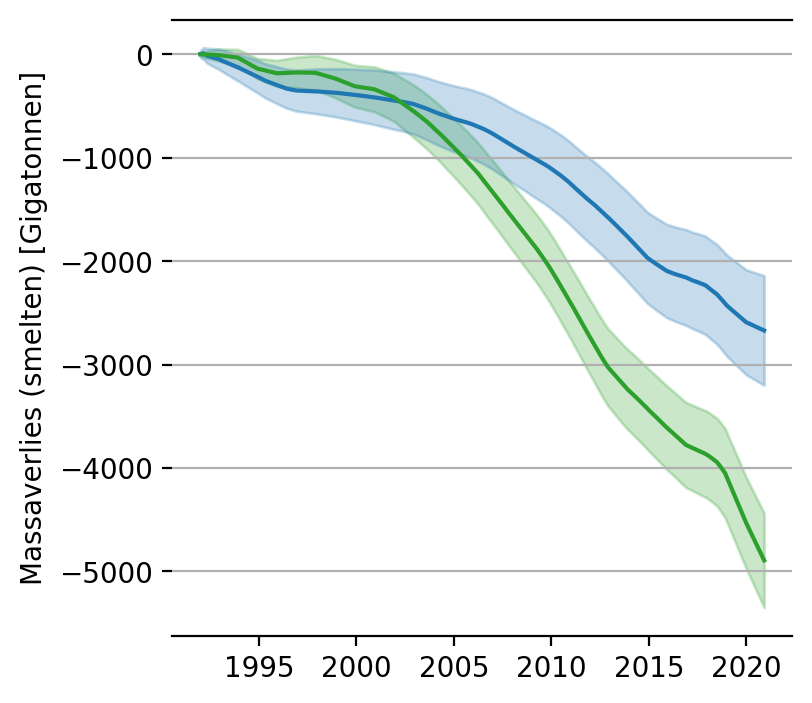

In [104]:
fig, ax = plt.subplots(figsize=(4,4))
alpha_val = 0.25

ax.fill_between(imbie_df.index, 
                imbie_df['GRIS_lb'], 
                imbie_df['GRIS_ub'], 
                color='tab:green',
                alpha=alpha_val,
               label='Groenland')
ax.fill_between(imbie_df.index, 
                imbie_df['AIS_lb'], 
                imbie_df['AIS_ub'], 
                color='tab:blue',
                alpha=alpha_val,
               label='Antarctica')

imbie_df['AIS'].plot(ax=ax, color='tab:blue', label='')
imbie_df['GRIS'].plot(ax=ax, color='tab:green', label='')

# Hide the left and right spines
ax.spines[['left', 'right']].set_visible(False)
ax.grid(axis='y')

plt.legend()
plt.xlabel('')
plt.ylabel('Massaverlies (smelten) [Gigatonnen]')

plt.savefig(f'{fig_dir}/Figure_brochure_sealevel_icesheets_Dutch.pdf', 
            bbox_inches="tight",
            dpi=150)

# ax.get_legend().remove()
# plt.savefig(f'{fig_dir}/Figure_brochure_sealevel_icesheets_Dutch_nolegend.pdf', 
#             bbox_inches="tight",
#             dpi=150)

### Scenario figure with only two scenarios

In [83]:
def make_proj_figure_brochure(proj_26, proj_85):
    
    fig, ax = plt.subplots(figsize=(5,5))
    alpha_val = 0.4
    
    center = '50'
    p_low = '5'
    p_high = '95'
    
    proj_26 = proj_26.sel(time=slice(2006,None))
    proj_85 = proj_85.sel(time=slice(2006,None))
    
    ax.fill_between(proj_26.time, 
                    proj_26.sel(proc='Total', percentiles=p_low), 
                    proj_26.sel(proc='Total', percentiles=p_high), 
                    color=rgb_yellow,
                    alpha=alpha_val,
                   label='ssp126')
    ax.fill_between(proj_85.time, 
                    proj_85.sel(proc='Total', percentiles=p_low), 
                    proj_85.sel(proc='Total', percentiles=p_high), 
                    color=rgb_red,
                    alpha=alpha_val,
                   label='ssp585')

    proj_26.sel(proc='Total', percentiles=center).plot(color=rgb_yellow)
    proj_85.sel(proc='Total', percentiles=center).plot(color=rgb_red)

    tg_19ra.plot(color='tab:blue',label='Tide gauge observations')

    plt.grid()
    plt.legend(loc='upper left')
    plt.xlabel('Time [years]')
    plt.ylabel('Sea level [cm]')
    
    return ax

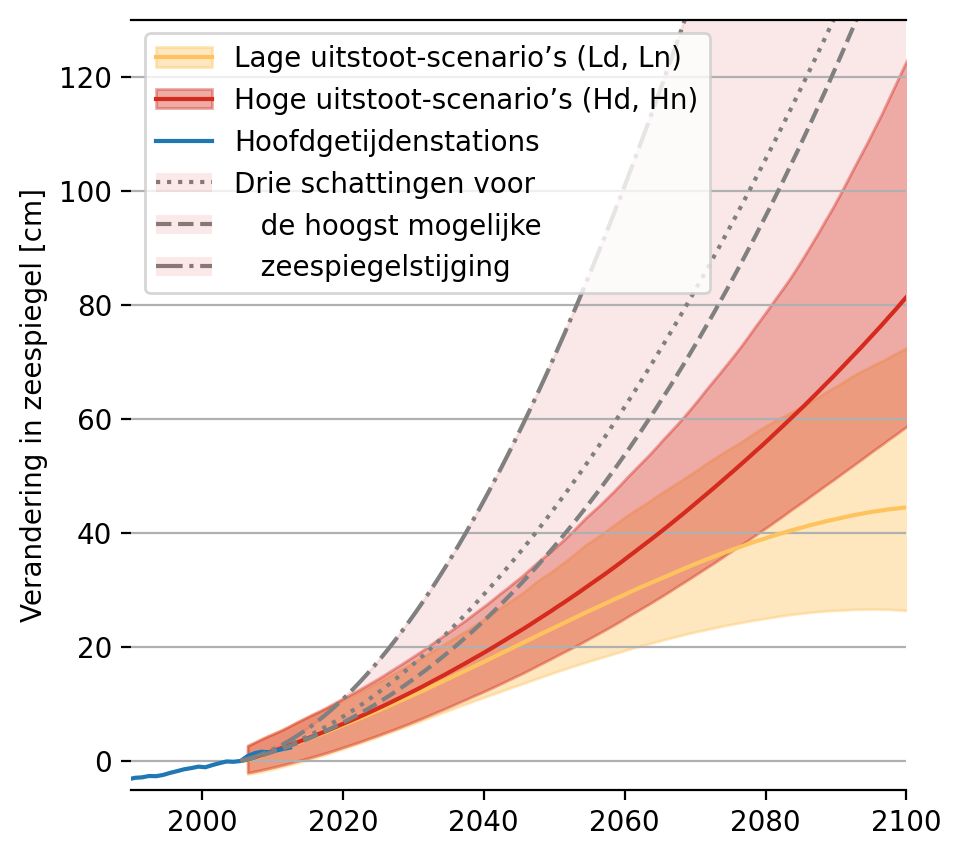

In [108]:
ax = make_proj_figure_brochure(KNMI23_ssp126, KNMI23_ssp585)

(lphi_ts_df*100).plot(ax=ax, color='grey', style=[':', '--', '-.'])

ax.fill_between(lphi_ts_df.loc[2006.5:2100.5].index, 
                KNMI23_ssp585.sel(proc='Total', 
                                  percentiles='95', 
                                  time=slice(2006.5,2100.5)).data, 
                lphi_ts_df.loc[2006.5:2100.5].max(axis=1)*100, 
                color='tab:red',
                alpha=0.1,
                label='')

ax.set_xlim([1990, 2100])
ax.set_ylim([-5, 130])
ax.set_xlabel('')
ax.set_ylabel('Verandering in zeespiegel [cm]')
ax.set_title('')

# Adjust the legend
handles, labels = ax.get_legend_handles_labels()

handles[0] = (Line2D([], [], color=rgb_yellow), handles[0])
handles[1] = (Line2D([], [], color=rgb_red), handles[1])

for i in [3, 4, 5]:
    handles[i] = (handles[i], Patch(facecolor=rgb_red, alpha=0.1))

labels[0] = 'Lage uitstoot-scenario’s (Ld, Ln)'
labels[1] = 'Hoge uitstoot-scenario’s (Hd, Hn)'
labels[2] = 'Hoofdgetijdenstations'

labels[3] = 'Drie schattingen voor'
labels[4] = '   de hoogst mogelijke'
labels[5] = '   zeespiegelstijging'
    
ax.legend(handles, labels)

# Hide the left and right spines
ax.spines[['left', 'right']].set_visible(False)
ax.grid(axis='y')

plt.savefig(f'{fig_dir}/Scenario_KNMI23_2100_brochure.pdf' ,dpi=150)

#ax.get_legend().remove()
#plt.savefig(f'{fig_dir}/Scenario_KNMI23_2100_brochure_nolegend.pdf' ,dpi=150)

In [107]:
lphi_ts_df

,Physical evidence discussion,Marine Ice Cliff Instability model,Structured Expert Judgement
time,,,
2005.5,0.000000,0.000000,0.000000
2006.5,0.003165,0.003109,0.003316
2007.5,0.006659,0.006437,0.007261
2008.5,0.010481,0.009986,0.011833
2009.5,0.014630,0.013758,0.017026
...,...,...,...
2296.5,9.766885,17.741669,13.146928
2297.5,9.813482,17.887347,13.184159
2298.5,9.860048,18.033787,13.220990


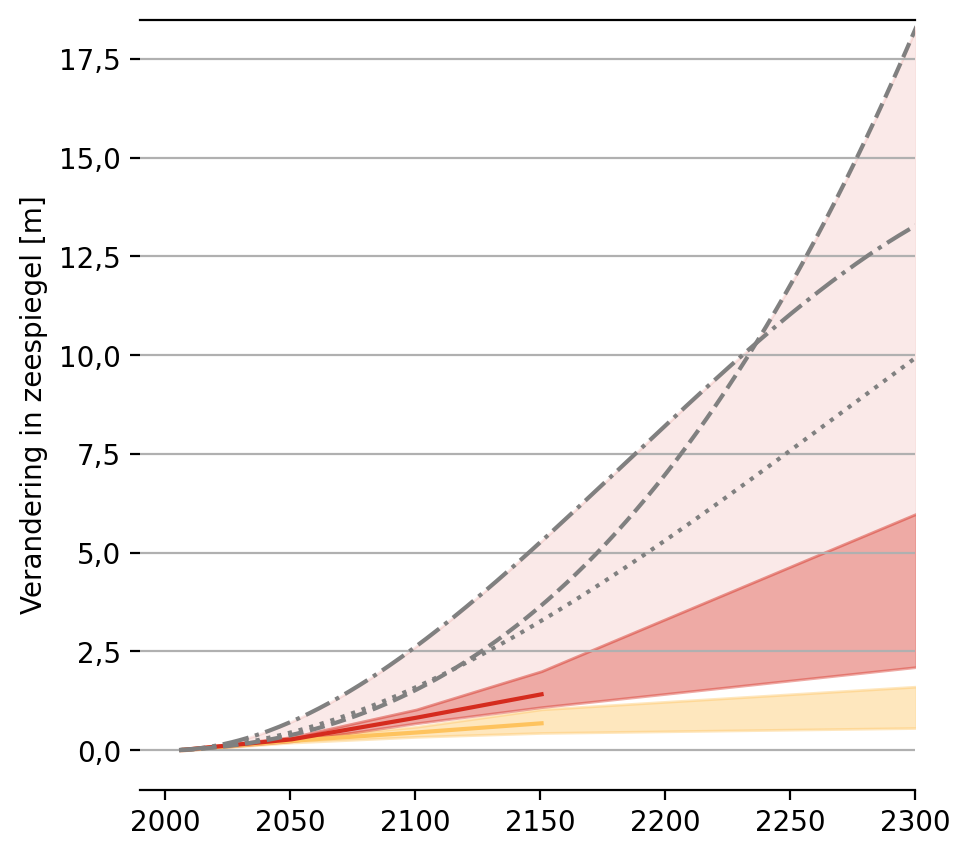

In [105]:
ax = make_long_proj_figure(long_df, proj_scen)

lphi_ts_df.plot(ax=ax, color='grey', style=[':', '--', '-.'])

ax.fill_between(lphi_ts_df.index, 
                long_df['ssp585_83'].reindex(lphi_ts_df.index).interpolate(), 
                lphi_ts_df.max(axis=1), 
                color=rgb_red,
                alpha=0.1,
                label='')

ax.set_xlabel('')
ax.set_ylabel('Verandering in zeespiegel [m]')

# Adjust the legend
handles, labels = ax.get_legend_handles_labels()

handles[0] = (Line2D([], [], color=rgb_yellow), handles[0])
handles[1] = (Line2D([], [], color=rgb_red), handles[1])

for i in [2, 3, 4]:
    handles[i] = (handles[i], Patch(facecolor=rgb_red, alpha=0.1))

labels[0] = 'Lage uitstoot-scenario’s (Ld, Ln)'
labels[1] = 'Hoge uitstoot-scenario’s (Hd, Hn)'

labels[2] = 'Drie schattingen voor'
labels[3] = '   de hoogst mogelijke'
labels[4] = '   zeespiegelstijging'
    
ax.legend(handles, labels)

# Modify the ticks
ticks = ax.get_yticks()
ticks_str = np.array(ticks, str)

for i in range(len(ticks_str)):
    ticks_str[i] = ticks_str[i].replace('.', ',')

ax.set_yticks(ticks)
ax.set_yticklabels(ticks_str)
    
ax.set_ylim([-1,18.5])
ax.set_xlim([1990, 2300])

# Hide the left and right spines
ax.spines[['left', 'right']].set_visible(False)
ax.grid(axis='y')

plt.savefig(f'{fig_dir}/Scenario_KNMI23_2300_brochure.pdf' ,dpi=150)

#ax.get_legend().remove()
#plt.savefig(f'{fig_dir}/Scenario_KNMI23_2300_brochure_nolegend.pdf' ,dpi=150)

Boxes tables, 6 boxes for the high emission scenario, how many fof the others?

In [100]:
59*6/82 

4.317073170731708

In [101]:
44*6/82 

3.2195121951219514